<a href="https://colab.research.google.com/github/acgowda/market-flow/blob/main/model/Data_Wrangling2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 8.4 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# imports
import yfinance as yf
import pandas as pd
import numpy as np
import zipfile
import pickle
from sklearn.preprocessing import StandardScaler
import datetime as dt

In [6]:
import tensorflow as tf

In [139]:
# get most recent list of SP500 tickers
def get_sp500_tickers():
    """
    Returns a data frame of the most recent
    S&P 500 tickers from the Wikipedia page
    on the S&P 500 Index

    Also saves a pickle file of the tickers for future use
    """
    tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol']

    with open('sp500_tickers','wb') as f:
        pickle.dump(tickers,f)
    return tickers

def get_nasdaq100_tickers():
    """
    Returns a data frame of the NASDAQ100 tickers from the 
    NASDAQ website

    Also saves a pickle file of the tickers for future use
    """
    tickers = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')[3]['Ticker']
    with open('nasdaq_tickers','wb') as f:
        pickle.dump(tickers,f)  
    return tickers 

def remove_inf(df):
    """
    Removes negative and positive infinities from our dataframe
    by replacing them with the minimum and maximum values from the column
    they are located in
    """
    # replace any infinite values with respective
    # max or min value of each column
    for col in df.columns:
        # indices where positive infinities are located
        p_ind = df[df[col]==np.inf].index
        # indices where negative infinities are located
        n_ind = df[df[col]==-np.inf].index
        # replacing the positive and negative infinities
        if len(p_ind) > 0:
            df[col].replace(np.inf,max(df[col].drop(p_ind,axis = 0)),inplace=True)
        if len(n_ind) > 0:
            df[col].replace(-np.inf,min(df[col].drop(n_ind,axis = 0)),inplace=True)
    return df

def create_target(df):
    """
    Used to create the target variable, which indicates
    if a stock will be up or down the next day
    """
    df = df.copy()
    #df['close'] = df['close'].pct_change()
    #df.dropna(inplace = True) #drop nan
    df['close'] = df['close'].apply(lambda x: 1 if x > 0 else 0)
    df['close'] = df['close'].shift(-1)
    return df

def create_salient_target(df):
    """
    Used to create the target variable, which indicates
    if a stock will be up or down the next day
    """
    df = df.copy()
    df['close'] = df['close'].pct_change()
    df.dropna(inplace = True) #drop nan
    
    df['close'] = np.where(df['close'] >= 0.03, 2,df['close'])
    df['close'] = np.where(df['close'] < 0.03 and df['close'] > -0.015, 1,df['close'])
    df['close'] = np.where(df['close'] <= -0.015, 0,df['close'])
    df['close'] = df['close'].shift(-1)

    return df

def create_close_MAs(df,MAs = [5,20,60,200]):
    """
    Create moving average columns of 'close'
    data column in our historical price dataset
    """
    df = df.copy()
    for ma in MAs:
        df[f'ma{ma}'] = df['close'].rolling(window=ma).mean()
    return df

def scale_df(df):
    # for normalising values in our indices' dataframe
    scaler = StandardScaler()
    cols = list(df.columns)
    i_ind = df.index
    df = pd.DataFrame(scaler.fit_transform(df),index = i_ind)
    df.columns = cols
    return df

def get_index_data(indices = ["^GSPC","^VIX"],period = '5y',
                   resolution='1d', MAs = [5,20,60,200]):
    """
    Obtain index data for our training dataset.

    Index data represents all other column-wise data
    that we will use to train our model.

    In this case, we used the following financial indices
    to train our model:
    ['^GSPC','^VIX']
    """

    main_df = pd.DataFrame()
    for ind in indices:
        # read in a specific indices' historical financial information
        df = yf.Ticker(ind).history(period=period,interval = resolution)

        # drop whichever columns work
        try:
          df.drop(['Dividends','Stock Splits','Open','Low','High'],axis = 1,inplace = True)
        except:
          df.drop(['Open','Low','High'],axis = 1,inplace = True)

        # lowercase the columns and label them
        for col in df.columns:
          df.rename(columns = {col:f'{ind}-{col.lower()}'},inplace = True)

        # create moving average columns
        for ma in MAs:
          df[f'{ind}-ma{ma}'] = df[f'{ind}-close'].rolling(window=ma).mean()

        # scale data frame w/ percent change
        # df = scale_df(df)
        df = df.pct_change()

        try:
            # if this column exists, it will be all NaNs,
            # so remove it
            df.drop(['^VIX-volume'],axis = 1,inplace = True)
        except:
            pass

        # forward fill any NA values
        df.fillna(method = 'ffill')
        # remove inf values potentially created
        df = remove_inf(df)

        # add this data to our final df
        if main_df.empty:
          main_df = df
        else:
          main_df = pd.concat([main_df,df],axis = 1)
    return main_df

def scale_df2(df):
    # normalise all columns except for the
    # column containing our closing price

    scaler = StandardScaler()
    y = df['close']
    X = df.drop(['close'],axis = 1)
    cols = list(X.columns)
    X = pd.DataFrame(scaler.fit_transform(X),index = y.index)
    df = pd.concat([y,X],axis = 1)
    df.columns = ['close'] + cols
    return df

def compile_data(tickers,indices = ["^GSPC","^VIX"],
                 period = '5y',
                 resolution = '1d',
                 MAs = [5,20,60,200]):
    """
    Compile all of the data
    we will use to train our model
    """
    main_df = pd.DataFrame() # our final dataframe
    count = 0 # keep track of progress

    # get extra financial information we want to use
    # in making predictions
    index_df = get_index_data(indices,period,resolution,MAs)

    if resolution not in ['1d','1wk']:
       return "Please specify your resolution as '1d' or '1wk'"

    for ticker in tickers:
        try:
            # yahoo finance doesn't like '.' full stops, and prefers '-' dashes
            ticker = ticker.replace('.', '-')
            # read in a specific ticker's historical financial information
            df = yf.Ticker(ticker).history(period = period,interval = resolution)
            # drop columns we won't be using from that dataframe
            df.drop(['Dividends','Stock Splits'],axis = 1,inplace = True)
            
            # make column names lower cased, because it's easier to type
            for col in df.columns:
                df.rename(columns = {col:col.lower()},inplace = True)

            # drop NAs for jic
            df.dropna(inplace = True)

            # add a few rolling window columns on our closing price
            df = create_close_MAs(df,MAs)

            # scale data frame w/ percent change
            # df = scale_df(df)
            df = df.pct_change()
            
            # fill foward missing values just in case any came up
            df.fillna(method = 'ffill')

            df = remove_inf(df) # remove inf values 

            # merge the extra financial info along the column-axis
            df = pd.concat([df,index_df], axis=1, ignore_index=False)

            # make our target variable
            df = create_target(df)
            
            # remove NaNs
            df.dropna(inplace = True,axis = 0)

            # add this data to our final df
            if main_df.empty:
                main_df = df
            else:
                main_df = pd.concat([main_df,df],axis = 0)
            
            # progress counting
            count +=1 # increment for every stock addded
            if count % 50 == 0: # will let us know progress for every 50 stocks added
                print(f'Progress: {count}/{len(tickers)}')
        except:
            continue
    
    # get day of week; 0 = Monday, ..., so on so forth
    # if the data is daily; add it to dataframe as a column
    if resolution == '1d':
      main_df['day'] = list(pd.Series(main_df.index).apply(lambda x: str(x.weekday())))

    # get month of year as a column
    main_df['month'] = list(pd.Series(main_df.index).apply(lambda x: str(x.month)))

    # convert categorical data to dummy variables
    main_df = pd.get_dummies(main_df)

    # drop any NaNs
    main_df = main_df.dropna(axis = 0)

    return main_df

def get_input_data(tickers,indices = ["^GSPC","^VIX"],
                   period = '5y',
                   resolution = '1d',
                   MAs = [5,20,60,200]):
    """
    Gets the data we need for model training or testing;
    Ensures that the dataset has equal number of buy/sell signals
    in it, so that our model training and testing process won't
    be biased

    Indices will default to "^GSPC","^VIX" which
    represent the S&P500 index and VIX index on
    yahoo finance, respectively
    """
    df = compile_data(tickers,indices,period,resolution,MAs)

    # obtain whichever is lower: the number of buy signals (1)
    # or the number of sell signals (0)
    lower = min(len(df.loc[df['close'] == 1]), len(df.loc[df['close'] == 0]))

    # balance our data: 
      # get dataframes of buys and sells which have the same number
      # of buy and sell signals
      # and combine them into a single dataframe
    # i.e. downsample whichever has more obs
    buys_df = df.loc[df['close'] == 1].sample(frac=lower/len(df.loc[df['close'] == 1]))
    sells_df = df.loc[df['close'] == 0].sample(frac=lower/len(df.loc[df['close'] == 0]))
    df_new = pd.concat([buys_df,sells_df],axis = 0)

    # shuffle the data
    df_new = df_new.sample(frac = 1)

    return df_new

def get_preds_data(ticker,indices = ["^GSPC","^VIX"],
                   period = '4y',
                   resolution = '1d',
                   MAs = [5,20,60,200]):
    """
    Get data for model to make predictions on
    """
    # yahoo finance doesn't like '.' full stops, and prefers '-' dashes
    ticker = ticker.replace('.', '-')
    # read in a specific ticker's historical financial information
    df = yf.Ticker(ticker).history(period = period,interval = resolution)
    index_df = get_index_data(indices,period,resolution,MAs)

    # drop columns we won't be using from that dataframe
    df.drop(['Dividends','Stock Splits'],axis = 1,inplace = True)
    # make column names lower cased, because it's easier to type
    for col in df.columns:
        df.rename(columns = {col:col.lower()},inplace = True)

    # drop NAs for jic
    df.dropna(inplace = True)
    
    # add a few rolling window columns on our closing price
    df = create_close_MAs(df,MAs)
    
    # normalise all columns as percentages
    df = df.pct_change()

    # fill foward missing values just in case any came up
    df.fillna(method = 'ffill')

    df = remove_inf(df) # remove inf values

    df = pd.concat([df,index_df], axis=1, ignore_index=False)

    df['returns'] = df['close']
    # merge the extra financial info along the column-axis
    df = create_target(df)

    # get day of week; 0 = Monday, ..., so on so forth
    # as a column
    if resolution == '1d':
      df['day'] = list(pd.Series(df.index).apply(lambda x: str(x.weekday())))

    # get month of year as a column
    df['month'] = list(pd.Series(df.index).apply(lambda x: str(x.month)))

    # convert categorical data to dummy variables
    df = pd.get_dummies(df)

    df.dropna(inplace=True)

    return df

## Data Stuff

In [ ]:
sp500_tickers =  get_sp500_tickers()
indices = ['^GSPC','^VIX','^IXIC','^DJI','^HSI','^FTSE','^FCHI','GC=F','CL=F']
period = '5y'
df = get_input_data(sp500_tickers,indices,period,
                    resolution = '1wk',
                    MAs = [4,21,52])

Progress: 50/504
Progress: 100/504
Progress: 150/504
Progress: 200/504
Progress: 250/504
Progress: 300/504
Progress: 350/504
Progress: 400/504
Progress: 450/504


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Progress: 500/504


In [ ]:
df.shape

(93212, 64)

In [ ]:
df.to_csv('weekly_stock_data4.csv')

In [47]:
df = pd.read_csv("/content/drive/Shareddrives/PIC 16B Project/weekly_stock_data4.csv",index_col = 0)

In [ ]:
df.shape

(93212, 64)

In [ ]:
#df = pd.read_csv("/content/drive/Shareddrives/PIC 16B Project/weekly_stock_data2.csv",index_col = 0)

In [ ]:
# df = pd.read_csv("/content/drive/Shareddrives/PIC 16B Project/weekly_stock_data_large.zip",index_col = 0,compression = 'zip')

In [48]:
df.describe().loc['max'][df.describe().loc['max'] > 10]

volume         25361.296296
GC=F-volume    23438.461538
Name: max, dtype: float64

In [49]:
high_change_cols = list(df.describe().loc['max'][df.describe().loc['max'] > 10].index)
high_change_cols

['volume', 'GC=F-volume']

In [50]:
df.drop(high_change_cols,axis = 1,inplace = True)

In [51]:
X = df.drop(['close'],axis = 1)
y = df['close']
y = np.asarray(y).astype('float32')

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42,
                                                    stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, 
                                                    test_size=0.25, 
                                                    random_state=42,
                                                    stratify=y_val)

In [53]:
sum(y_train)/len(y_train)

0.5000071521549443

In [54]:
sum(y_val)/len(y_val)

0.49997139097099047

In [55]:
sum(y_test)/len(y_test) # model base rate

0.5

## Model

### RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=300)
rf.fit(X_train,y_train)
preds = rf.predict(X_val) 
np.mean(preds == y_val)

0.7020872865275142

### NN

In [56]:
X_train = np.asarray(X_train).astype('float32')
X_val = np.asarray(X_val).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_train = y_train.reshape(-1,)
y_val = y_val.reshape(-1,)
y_test = y_test.reshape(-1,)

In [57]:
print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")
print(f"TRAIN sells: {np.sum(y_train == 0)}, buys: {np.sum(y_train == 1)}")
print(f"VALIDATION sells: {np.sum(y_val == 0)}, buys: {np.sum(y_val == 1)}")
print(f"TEST sells: {np.sum(y_test == 0)}, buys: {np.sum(y_test == 1)}")

Train: 69909, Validation: 17477, Test: 5826
TRAIN sells: 34954, buys: 34955
VALIDATION sells: 8739, buys: 8738
TEST sells: 2913, buys: 2913


In [58]:
import tensorflow as tf
from tensorflow import keras
def build_model():
  model = tf.keras.Sequential([
    # classification
    # input
    keras.layers.Dense(64,input_shape = X_train.shape[1:]),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(0.2),
    
    # hidden 1
    keras.layers.Dense(64),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(0.2),
    
    # hidden 2
    keras.layers.Dense(64),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(0.2),

    # output
    keras.layers.Dense(1) 
  ])
  return model

In [59]:
model = build_model()

# compile our model with relevant optimizer, loss function, and metrics
model.compile(optimizer = keras.optimizers.Adam(),
            # from_logits = True to apply softmax layer at end
            loss = tf.keras.losses.BinaryCrossentropy(from_logits = True), 
            metrics = ['accuracy'])

#tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3968      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                        

In [61]:
checkpoint_filepath = '/tmp/checkpoint' # create a checkpoint filepath for saving our model

# callback function for our model
# we want to save the best model's weights 
# best is based on validation accuracy in our training phase
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, save_weights_only=True,
    monitor='val_accuracy',mode='max',
    save_best_only=True)

# PATIENT EARLY STOPPING
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      mode='min', verbose=1,
                                      patience=15)

# fit and train the model
history = model.fit(X_train,y_train,
                    batch_size=64,
                    epochs = 20, 
                    validation_data = (X_val,y_val),
                    callbacks=[model_checkpoint_callback,
                               es],
                    verbose = True
                    )

Epoch 1/20
1093/1093 [==============================] - 8s 5ms/step - loss: 0.6724 - accuracy: 0.5687 - val_loss: 0.6071 - val_accuracy: 0.6070
Epoch 2/20
1093/1093 [==============================] - 5s 4ms/step - loss: 0.6269 - accuracy: 0.6183 - val_loss: 0.5848 - val_accuracy: 0.6452
Epoch 3/20
1093/1093 [==============================] - 4s 4ms/step - loss: 0.6099 - accuracy: 0.6387 - val_loss: 0.5774 - val_accuracy: 0.6531
Epoch 4/20
1093/1093 [==============================] - 4s 4ms/step - loss: 0.5997 - accuracy: 0.6459 - val_loss: 0.5745 - val_accuracy: 0.6627
Epoch 5/20
1093/1093 [==============================] - 4s 4ms/step - loss: 0.5933 - accuracy: 0.6539 - val_loss: 0.5699 - val_accuracy: 0.6655
Epoch 6/20
1093/1093 [==============================] - 4s 4ms/step - loss: 0.5901 - accuracy: 0.6561 - val_loss: 0.5679 - val_accuracy: 0.6638
Epoch 7/20
1093/1093 [==============================] - 4s 4ms/step - loss: 0.5873 - accuracy: 0.6565 - val_loss: 0.5656 - val_accuracy:

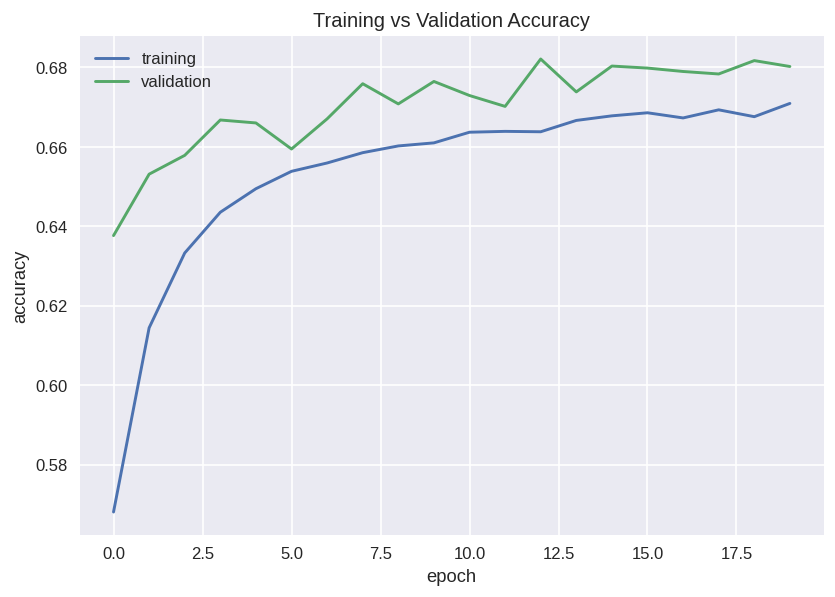

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 120
mpl.style.use('seaborn')

def plot_history(history):  
  plt.plot(history.history["accuracy"], label = "training")
  plt.plot(history.history["val_accuracy"], label = "validation")
  plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
  plt.title("Training vs Validation Accuracy")
  plt.legend()
  plt.show()

plot_history(history)

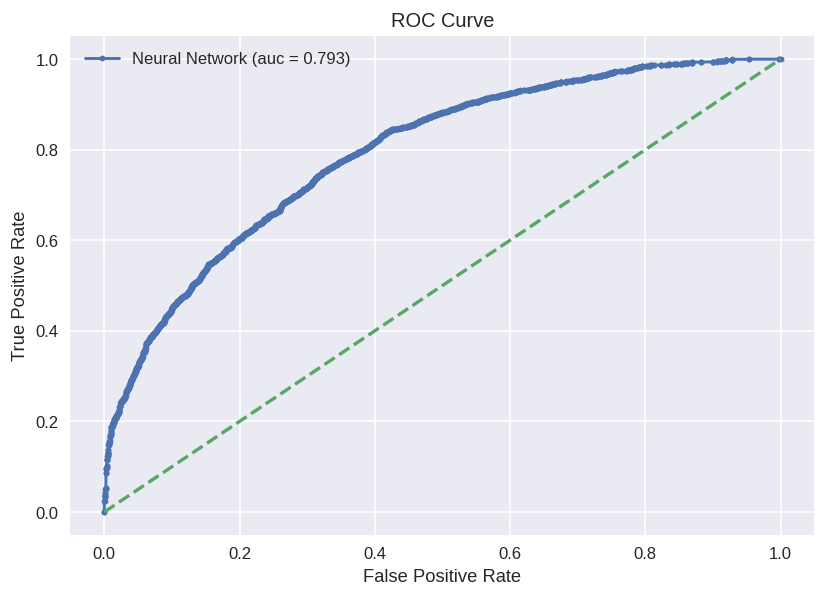

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc(model, X_test, y_test):
  y_pred = model.predict(X_test).ravel()
  nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_pred)
  auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
  fig,ax = plt.subplots(1)
  ax.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)
  x = np.linspace(*ax.get_xlim())
  ax.plot(np.linspace(0,1,2),linewidth=2,linestyle = "dashed")
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  ax.legend()
  plt.title('ROC Curve')
  plt.show()
plot_roc(model, X_test, y_test)

#np.linspace()

In [96]:
model.load_weights(checkpoint_filepath)

In [97]:
model.evaluate(X_test,y_test)

183/183 [==============================] - 0s 2ms/step - loss: 0.5704 - accuracy: 0.6710


[0.5704169869422913, 0.6709578037261963]

In [ ]:
#!mkdir -p models
model.save('models/weekly_model') 

INFO:tensorflow:Assets written to: models/weekly_model/assets


## Testing Weekly

In [7]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/PIC 16B Project/model_week')

In [10]:
#nasdaq_tickers = get_nasdaq100_tickers()
#ticks = [t for t in nasdaq_tickers if t not in list(sp500_tickers)]
#indices = ['^GSPC','^VIX','^IXIC','^DJI','^HSI','^FTSE','^FCHI','GC=F','CL=F']
#period = '5y'
#test_df = get_preds_data('TSLA',indices,period,resolution = '1wk',MAs = [4,21,52])

In [154]:
indices = ['^GSPC','^VIX','^IXIC','^DJI','^HSI','^FTSE','^FCHI','GC=F','CL=F']
period = '2y'
ticker = 'SPY' #any ticker
test_df = get_preds_data(ticker,
                    indices,
                    period,
                    resolution = '1wk',
                    MAs = [4,21,52])

In [155]:
test_df.tail()

,open,high,low,close,volume,ma4,ma21,ma52,^GSPC-close,^GSPC-volume,...,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-09,-0.016915,-0.054113,-0.049059,0.0,-0.092919,-0.021379,-0.005931,-0.000413,-0.024119,0.101087,...,0,0,0,0,0,1,0,0,0,0
2022-05-16,-0.012639,0.005315,-0.011969,1.0,-0.228040,-0.022052,-0.008607,-0.000871,-0.030451,-0.111197,...,0,0,0,0,0,1,0,0,0,0
2022-05-23,-0.017876,0.016668,0.016871,0.0,-0.162970,0.002019,-0.006358,0.000030,0.065844,-0.070490,...,0,0,0,0,0,1,0,0,0,0
2022-05-30,0.052745,0.004959,0.051607,1.0,-0.216552,-0.000494,-0.005945,-0.000288,-0.011952,-0.161406,...,0,0,0,0,0,1,0,0,0,0
2022-06-06,0.002974,-0.001988,0.001671,0.0,-0.650974,0.008670,-0.005255,-0.000134,0.012691,-0.543393,...,0,0,0,0,0,0,1,0,0,0


In [156]:
high_change_cols = ['volume','GC=F-volume','returns']

In [157]:
test_df.drop(high_change_cols,axis = 1,inplace = True)

In [158]:
y_val = np.asarray(test_df['close'])
y_val = y_val.reshape(-1,)
X_val = test_df.drop(['close'],axis = 1)
X_val = np.asarray(X_val).astype('float32')

In [160]:
model.evaluate(X_val,y_val)

2/2 [==============================] - 0s 10ms/step - loss: 0.4504 - accuracy: 0.7170


[0.45044398307800293, 0.7169811129570007]

## Testing Daily

In [ ]:
sp500_tickers =  get_sp500_tickers()
nasdaq_tickers = get_nasdaq100_tickers()
indices = ['^GSPC','^VIX','^IXIC','^DJI','^HSI','^FTSE','^FCHI','GC=F','CL=F']
period = '5y'

In [ ]:
test_tickers = [t for t in nasdaq_tickers if t not in sp500_tickers]

NameError: ignored

In [ ]:
df_val = get_preds_data(ticker = test_tickers[1], 
                        indices = indices,
                        period = period, 
                        resolution = '1wk')

NameError: ignored

In [ ]:
df_val.shape

(61, 127)

In [ ]:
df_val.drop(['week_53'],axis = 1,inplace = True)

In [ ]:
y_val = np.asarray(df_val['close'])
y_val = y_val.reshape(-1,)
X_val = df_val.drop(['close'],axis = 1)
X_val = np.asarray(X_val).astype('float32')

In [ ]:
X_val.shape

(61, 125)

In [ ]:
model.evaluate(X_val,y_val)

2/2 [==============================] - 0s 10ms/step - loss: 20.9426 - accuracy: 0.5574


[20.942596435546875, 0.5573770403862]